# Galaxy vs Quasar

### WIP - Unfinished!!

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import (precision_recall_curve, roc_curve)

from astropy.io import ascii

plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['font.size'] = 12
plt.rcParams['figure.dpi'] = 500

In [2]:
data = ascii.read('../solutions/galaxyquasar.csv', header_start=0)

In [3]:
data

u,g,r,i,z,class,z1,zerr
float64,float64,float64,float64,float64,str6,float64,float64
18.97213,18.53676,18.5828,18.34936,18.29215,QSO,0.5228189,0.0001547483
19.24592,17.47646,16.47817,16.04472,15.68851,GALAXY,0.1228459,2.816076e-05
19.43536,17.70268,16.91565,16.58327,16.39128,GALAXY,0.0,0.0
19.31626,18.18312,17.39591,16.94549,16.65395,GALAXY,0.1474355,9.310701e-06
19.28828,19.11188,18.88937,18.80013,18.49183,QSO,2.011455,0.0006307968
17.60994,15.90911,15.0209,14.54955,14.19971,GALAXY,0.04619161,1.022329e-05
18.50014,17.42286,17.03657,16.76236,16.63258,GALAXY,0.0516851,6.667251e-06
19.53253,19.49823,19.42254,19.07912,18.90426,QSO,1.88844,0.0005242734
19.37014,17.94086,17.154,16.74367,16.42825,GALAXY,0.137445,1.284492e-05


In [7]:
u_g = (data['u'] - data['g'])[:, None]
g_r = (data['g'] - data['r'])[:, None]
r_i = (data['r'] - data['i'])[:, None]
i_z = (data['i'] - data['z'])[:, None]

kind = []

for i in data['class']:
    if i == 'QSO':  #Quasar Label
        kind.append(1)
    elif i == 'GALAXY':     #Galaxy label
        kind.append(0)

kind = np.array(kind)

In [13]:
fast_kind = np.where(data['class'] == 'QSO', 1, 0)

In [14]:
fast_kind

array([1, 0, 0, ..., 0, 0, 0])

In [15]:
fast_kind.shape

(50000,)

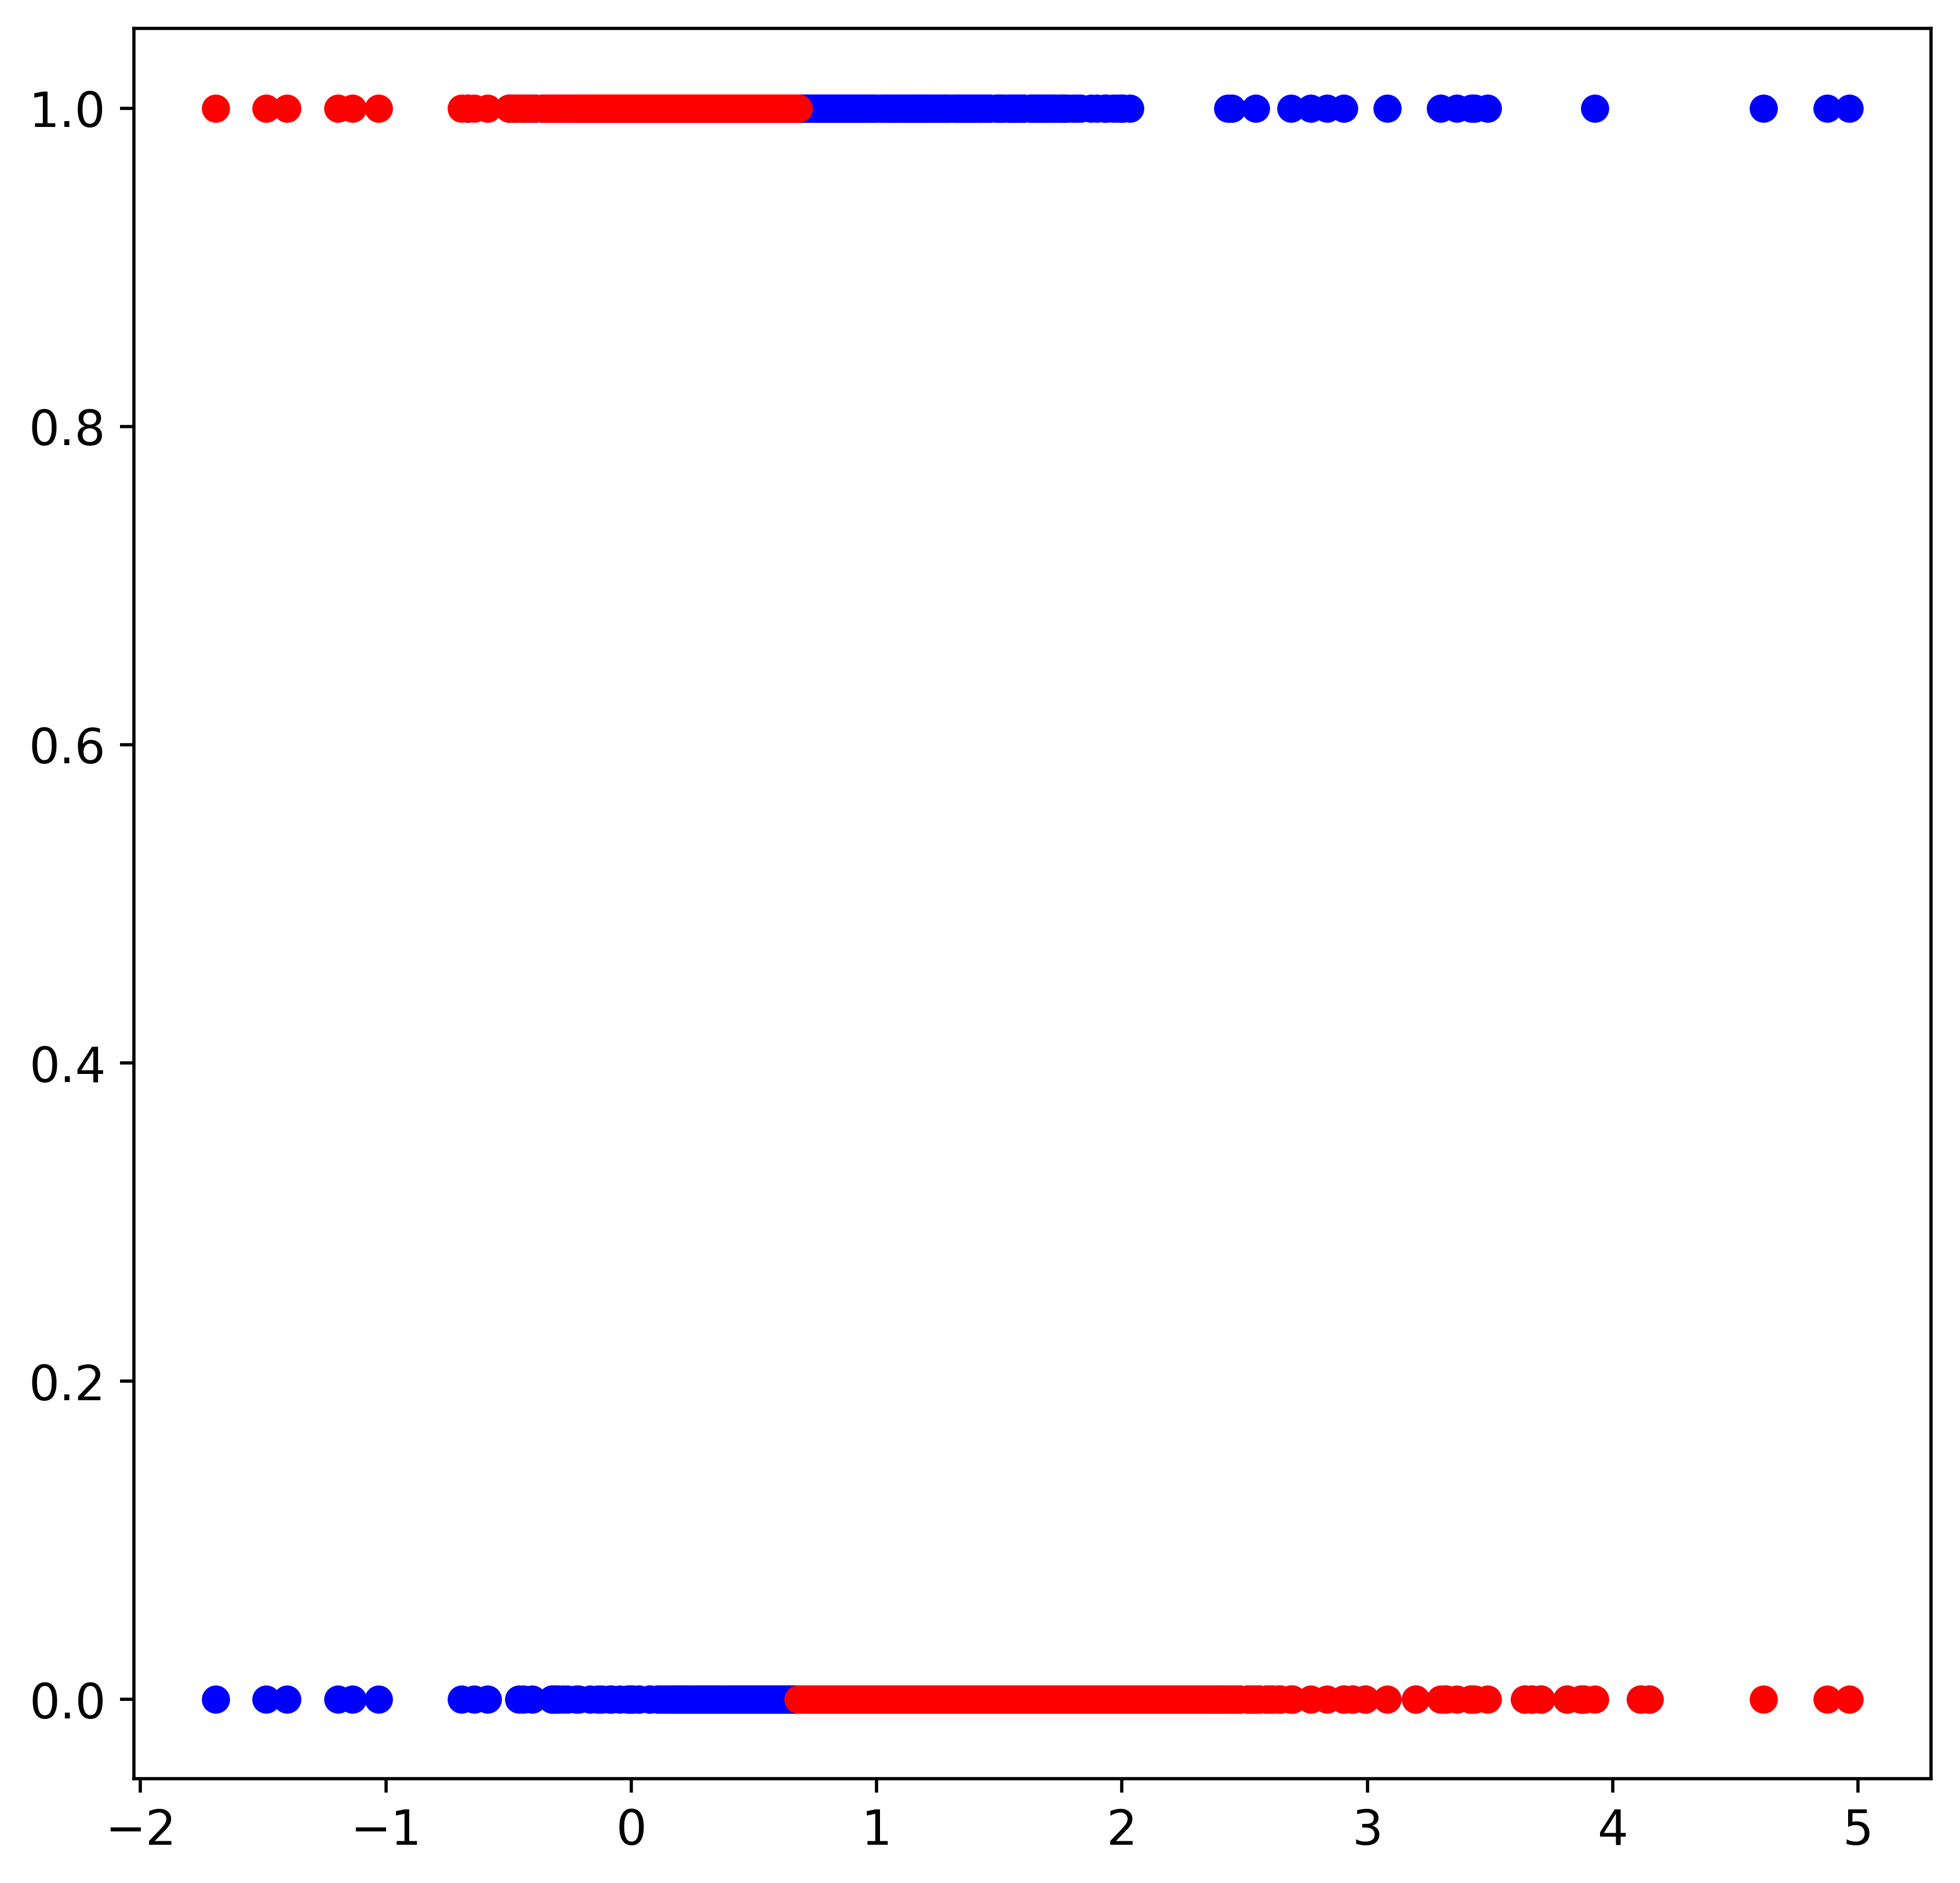

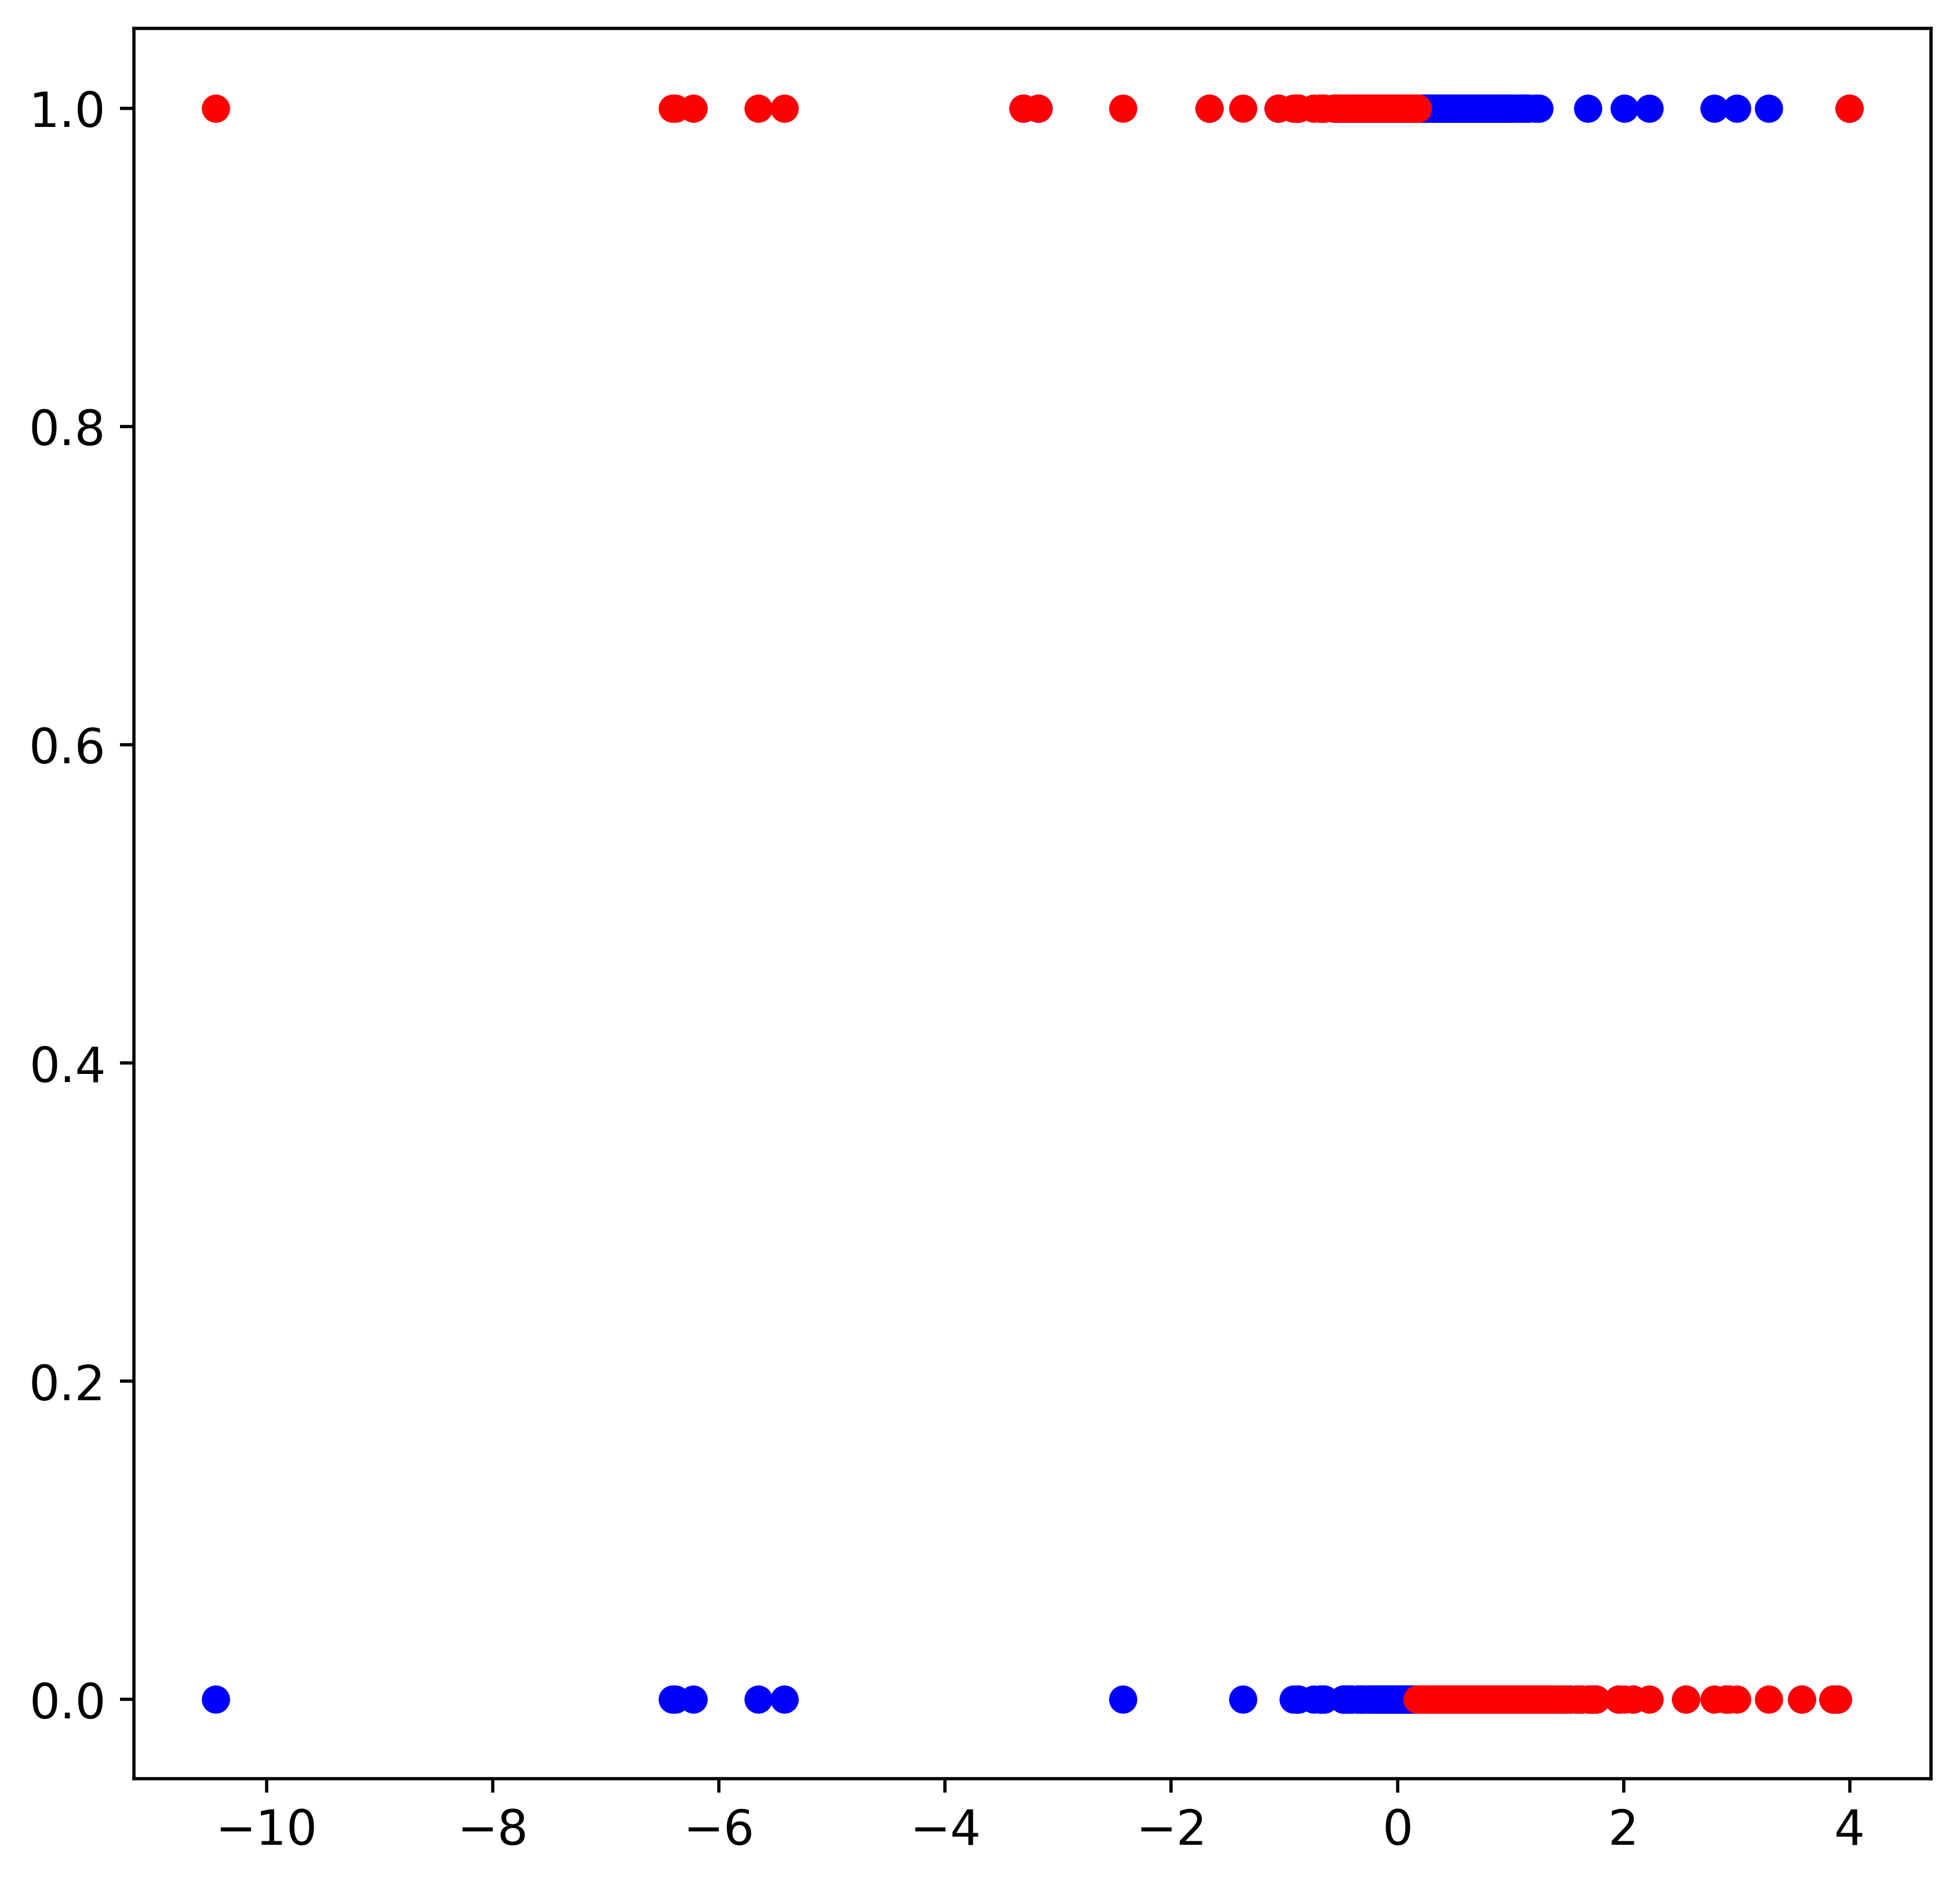

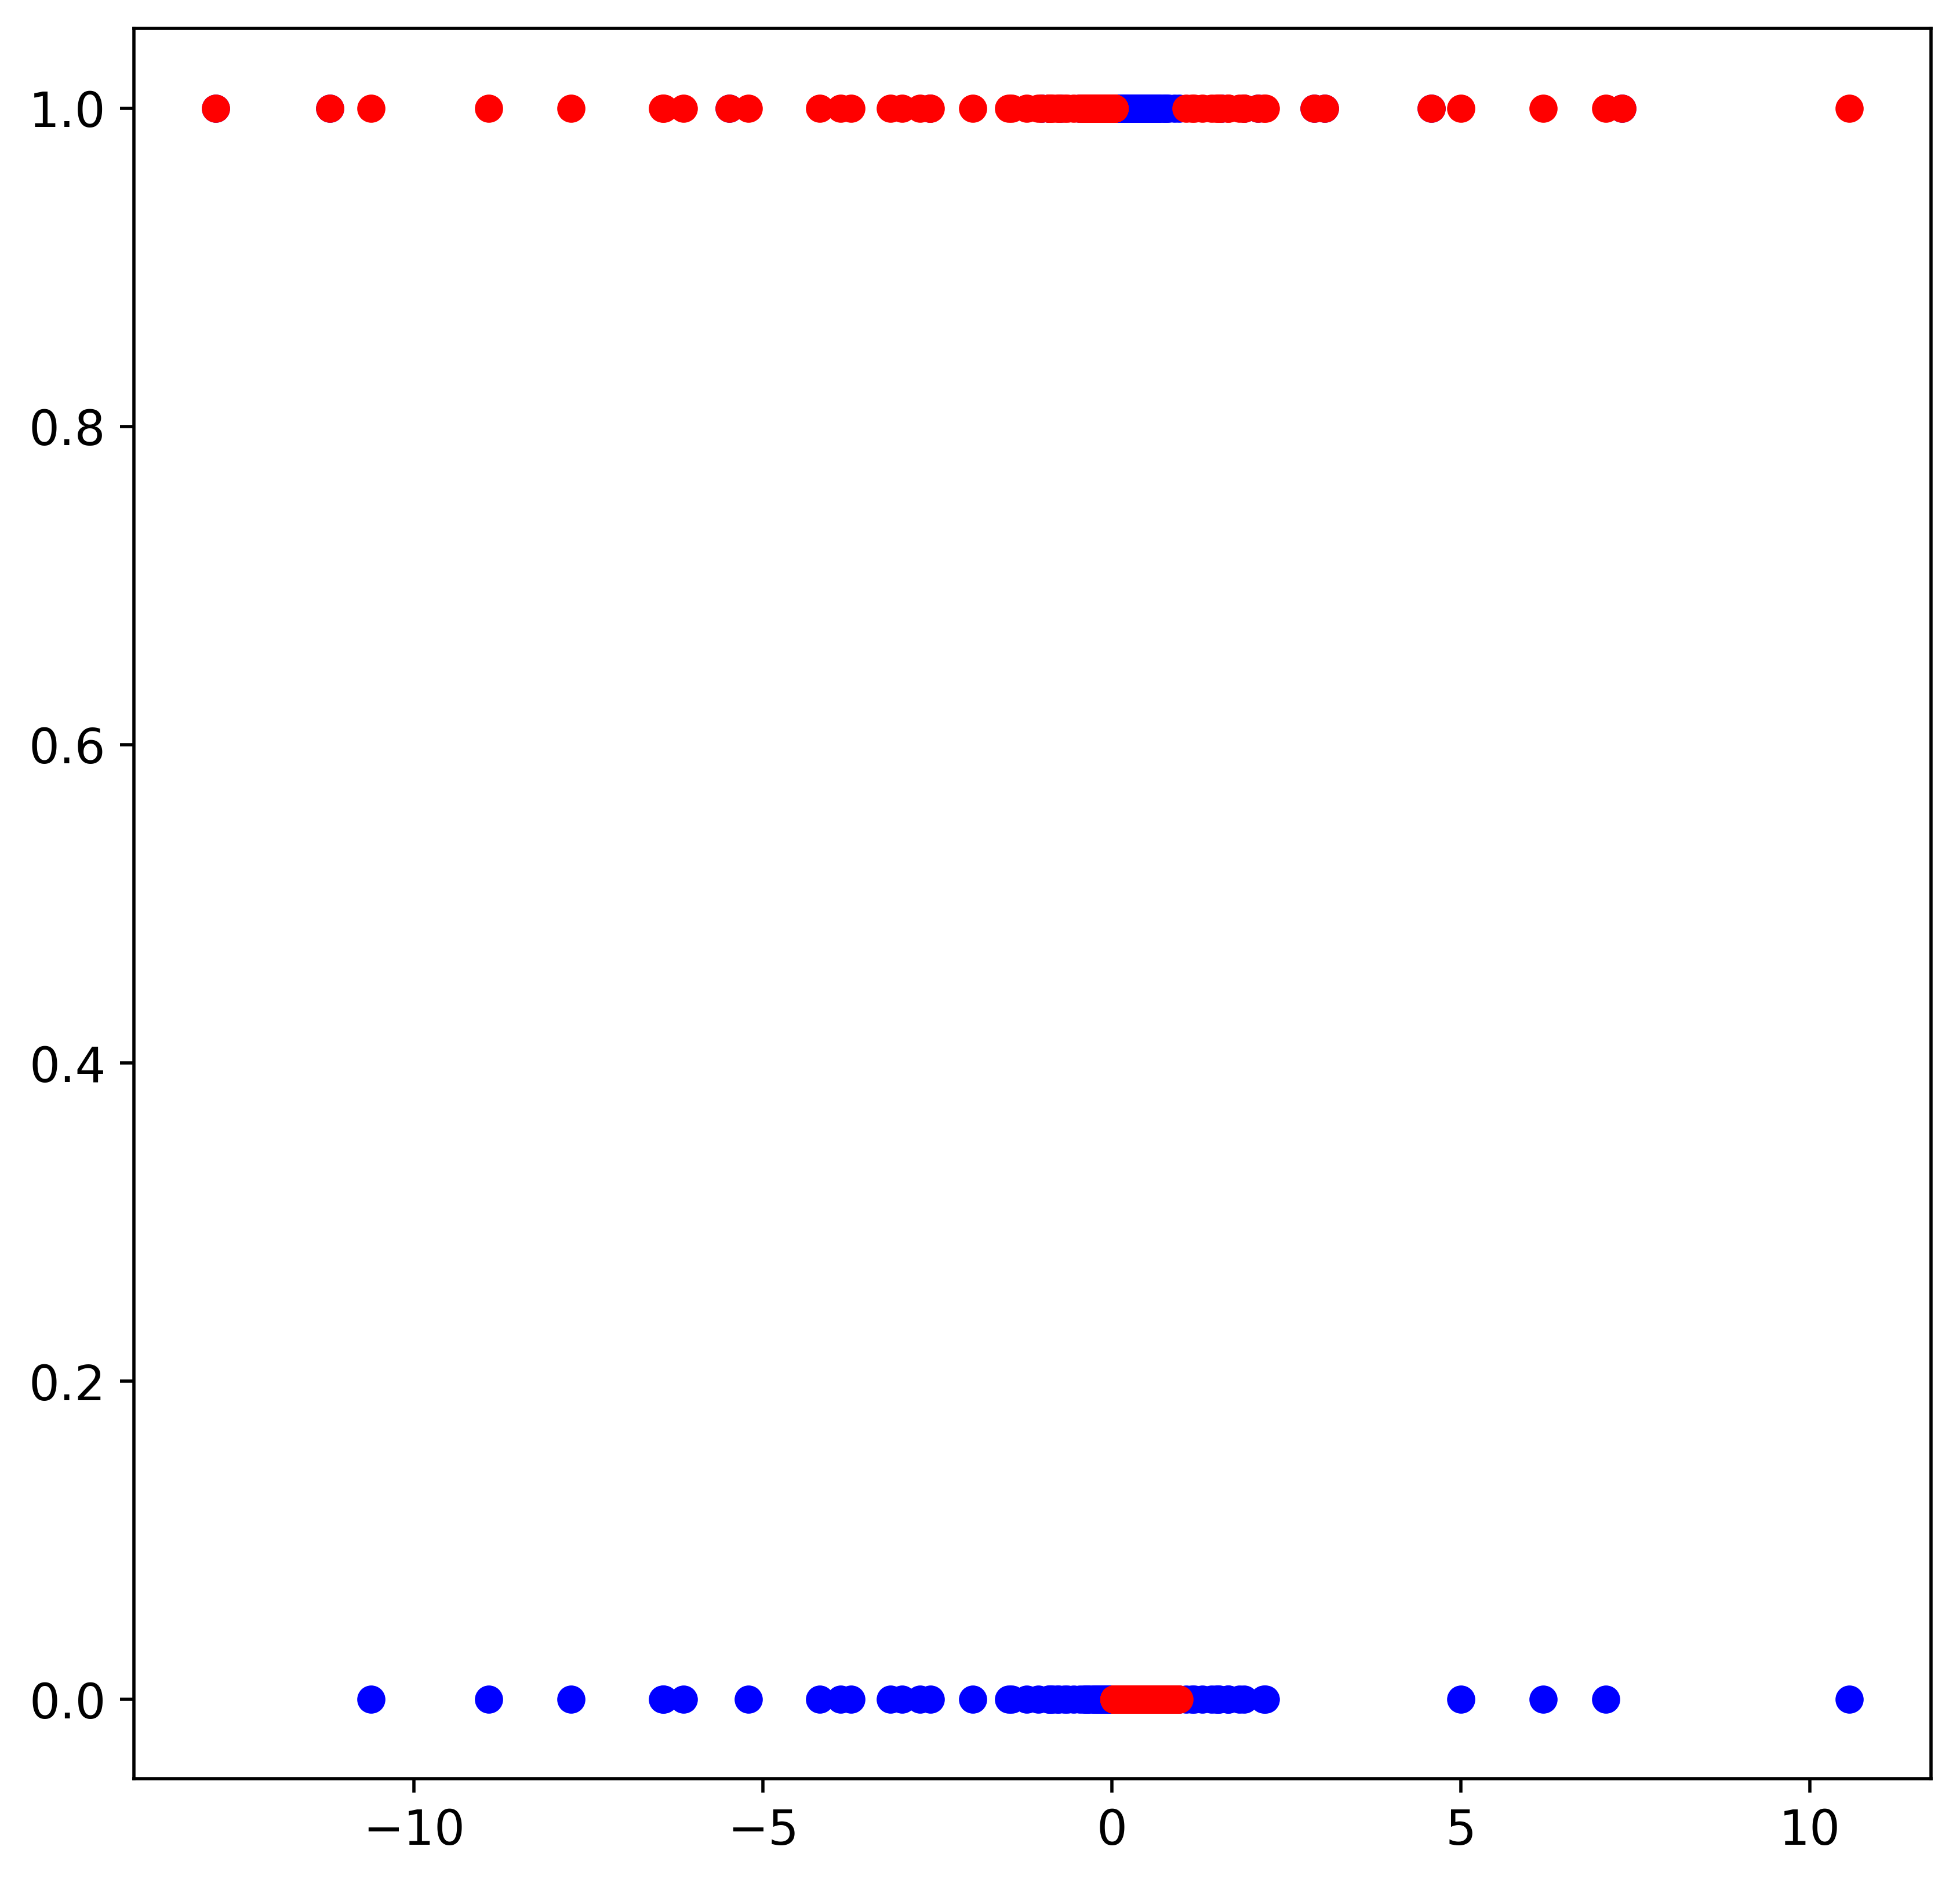

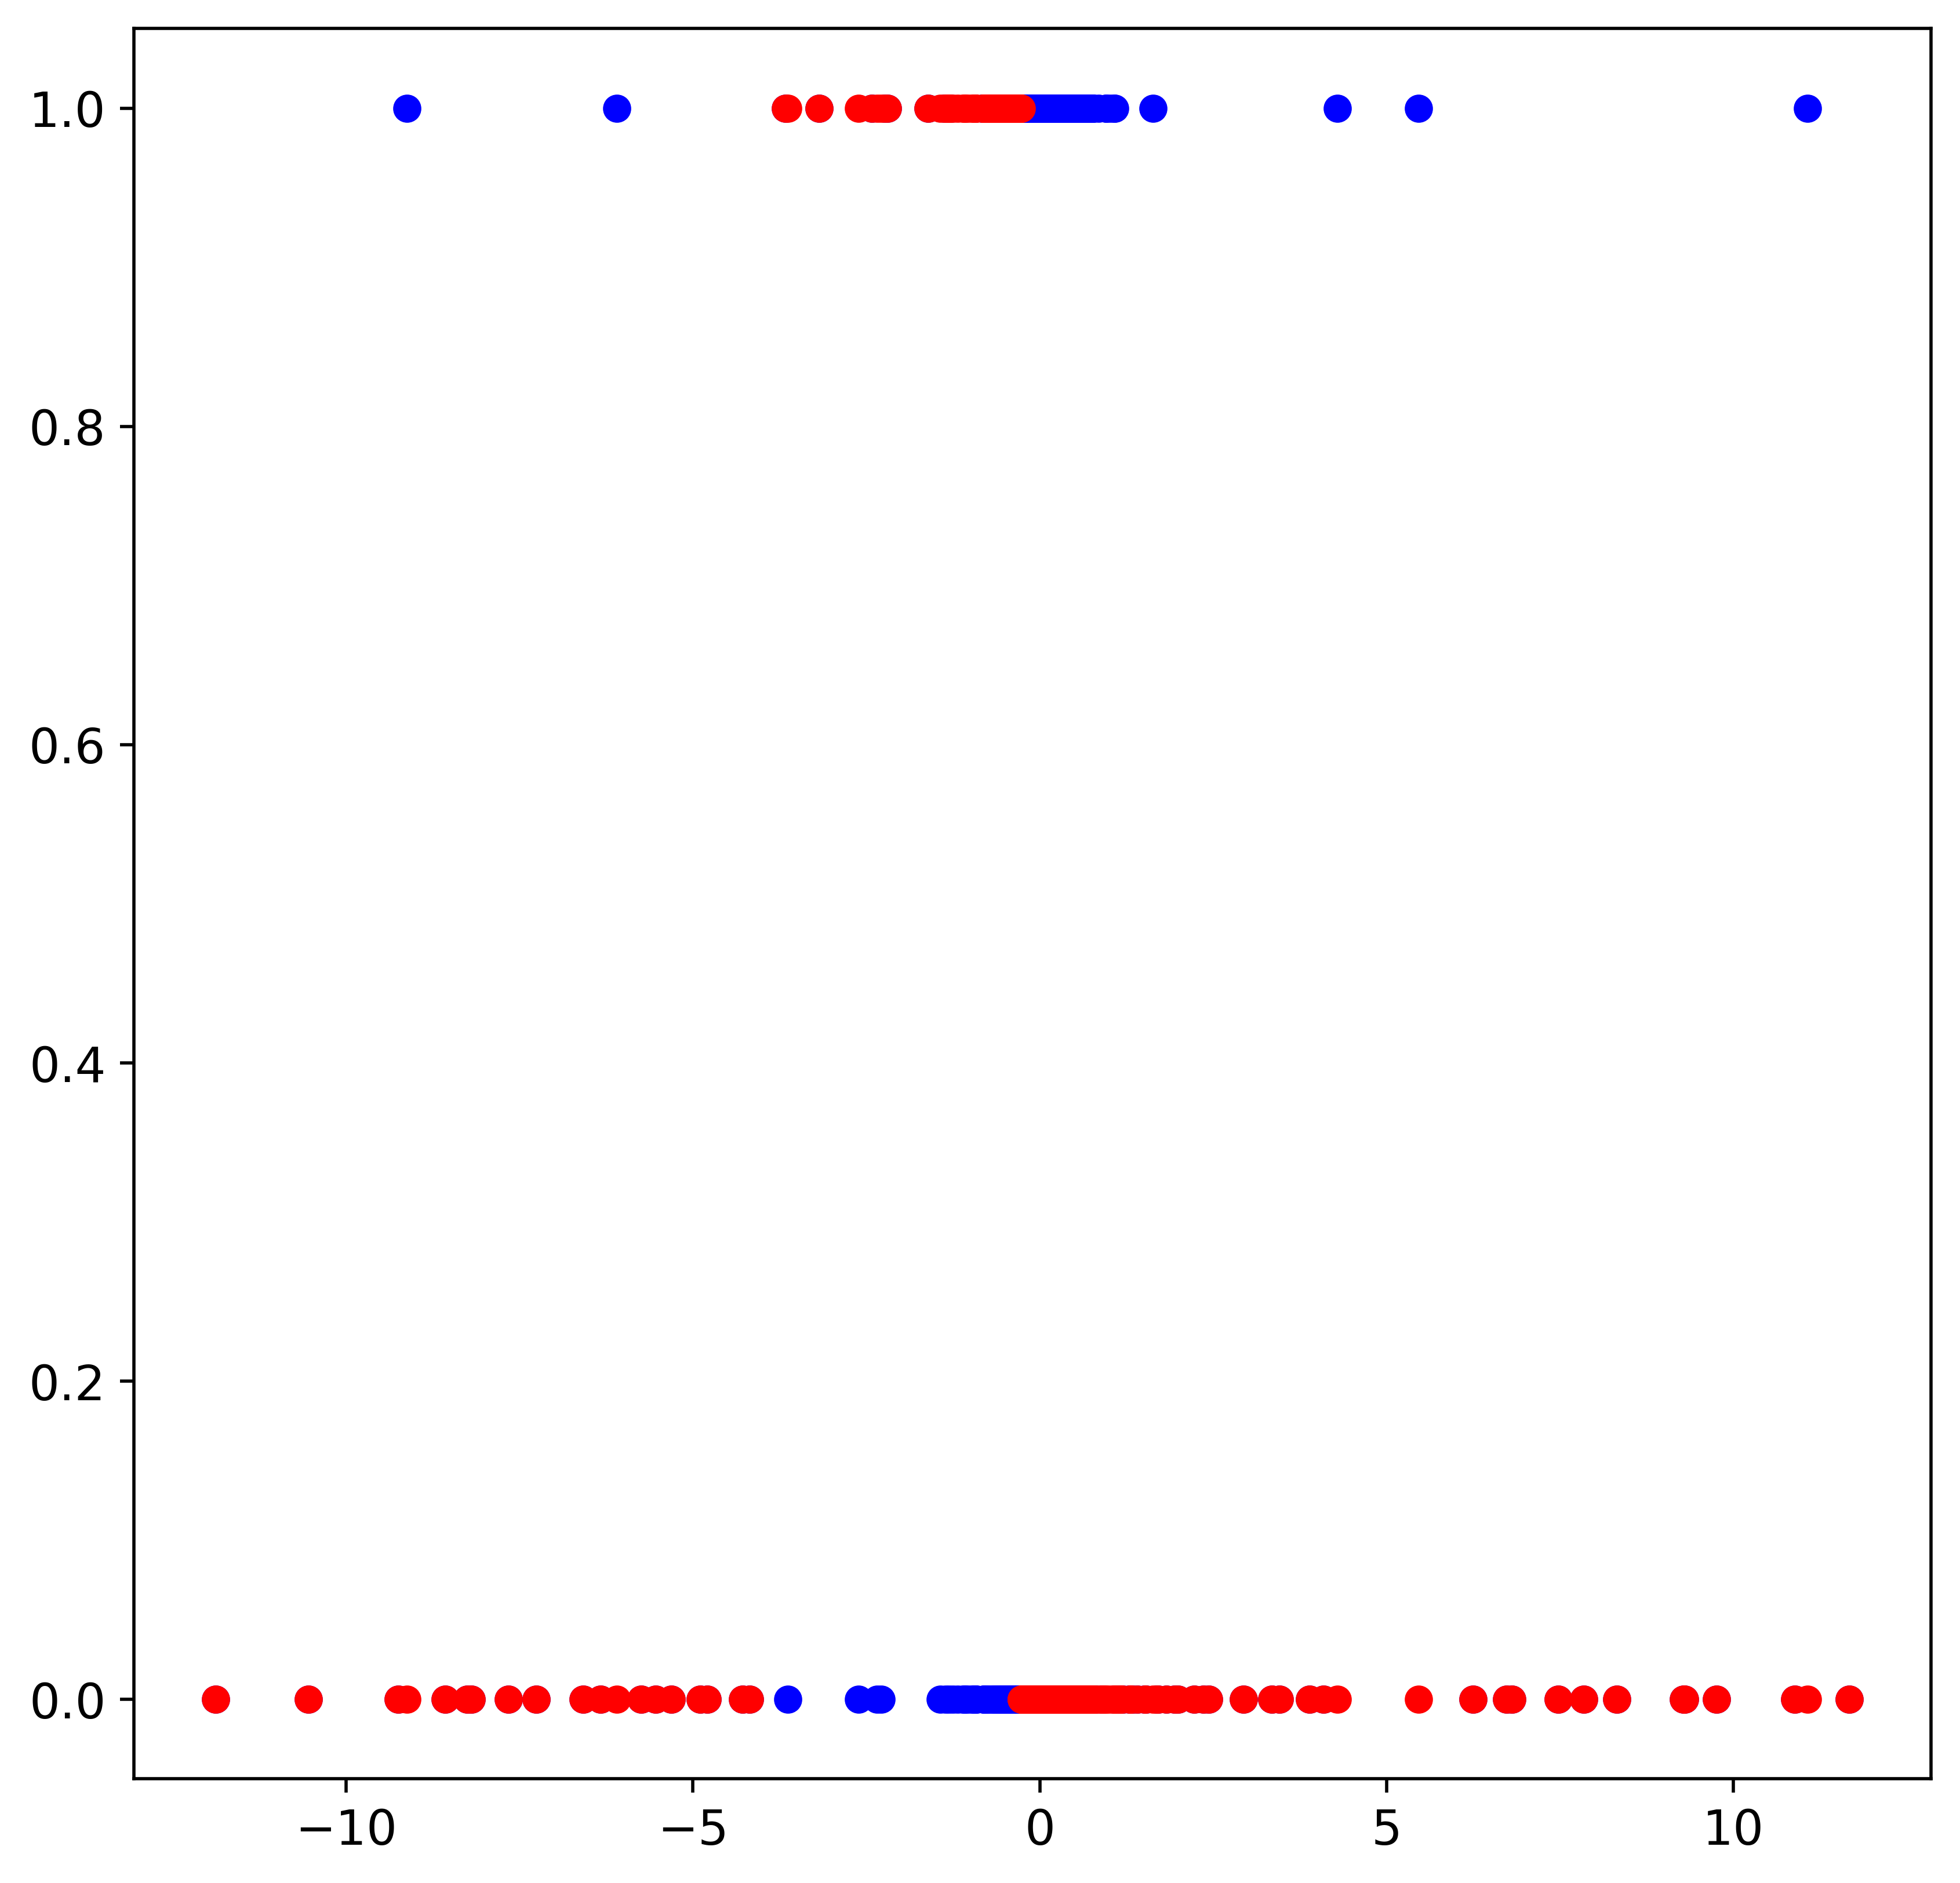

In [20]:
classifier = GaussianNB()

for array in (u_g, g_r, r_i, i_z):
    xtrain, xtest, ytrain, ytest = sklearn.model_selection.train_test_split(array, fast_kind, test_size = 0.75)

    classifier.fit(xtrain, ytrain)
    result = classifier.predict(xtest)

    plt.scatter(xtest, ytest, c='blue')
    plt.scatter(xtest, result, c='red')
    plt.show()


